In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_curve, auc, confusion_matrix
)
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import seaborn as sns
import optuna

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


c:\Users\AIML\anaconda3\envs\aiml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
# Load dataset
df = pd.read_csv('balanced_dataset.csv')
X = df[['text', 'useful']]
y = df['target']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the "useful" column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train['useful'] = scaler.fit_transform(X_train[['useful']])
X_test['useful'] = scaler.transform(X_test[['useful']])

# Tokenizer for text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to pad and truncate sequences
def pad_sequences(input_ids, max_length):
    padded_input_ids, attention_masks = [], []
    for seq in input_ids:
        if len(seq) < max_length:
            padded_seq = seq + [0] * (max_length - len(seq))
            attention_mask = [1] * len(seq) + [0] * (max_length - len(seq))
        else:
            padded_seq = seq[:max_length]
            attention_mask = [1] * max_length
        padded_input_ids.append(padded_seq)
        attention_masks.append(attention_mask)
    return padded_input_ids


# Function to process text
def process_text(text_series):
    encodings = [tokenizer.encode_plus(text, add_special_tokens=True, max_length=128) for text in text_series]
    input_ids = [e['input_ids'] for e in encodings]
    return pad_sequences(input_ids, max_length=128), pad_sequences([[1] * len(seq) for seq in input_ids], max_length=128)


# Tokenize and pad text data
train_text_ids, train_attention_mask = process_text(X_train['text'])
test_text_ids, test_attention_mask = process_text(X_test['text'])

# Convert to tensors
train_text_ids = torch.tensor(train_text_ids, dtype=torch.long)
train_attention_mask = torch.tensor(train_attention_mask, dtype=torch.long)
test_text_ids = torch.tensor(test_text_ids, dtype=torch.long)
test_attention_mask = torch.tensor(test_attention_mask, dtype=torch.long)

# Convert numerical feature to tensors
train_useful = torch.tensor(X_train['useful'].values, dtype=torch.float32)
test_useful = torch.tensor(X_test['useful'].values, dtype=torch.float32)

# Map labels
label_mapping = {'genuine': 0, 'fake': 1}
y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)

train_labels = torch.tensor(y_train.values, dtype=torch.long)
test_labels = torch.tensor(y_test.values, dtype=torch.long)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [3]:
class TextAndFeatureDataset(Dataset):
    def __init__(self, text_ids, attention_masks, numerical_features, labels):
        self.text_ids = text_ids
        self.attention_masks = attention_masks
        self.numerical_features = numerical_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'text_ids': self.text_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'useful': self.numerical_features[idx],
            'labels': self.labels[idx]
        }


In [4]:
train_dataset = TextAndFeatureDataset(
    text_ids=train_text_ids,
    attention_masks=train_attention_mask,
    numerical_features=train_useful,
    labels=train_labels
)

test_dataset = TextAndFeatureDataset(
    text_ids=test_text_ids,
    attention_masks=test_attention_mask,
    numerical_features=test_useful,
    labels=test_labels
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
class CustomAlbertModel(torch.nn.Module):
    def __init__(self, albert_model_name='bert-base-uncased', num_labels=2):
        super(CustomAlbertModel, self).__init__()
        self.albert = BertForSequenceClassification.from_pretrained(albert_model_name, num_labels=num_labels)
        self.feature_layer = torch.nn.Linear(1, 16)  # Process "useful" feature
        self.classifier = torch.nn.Linear(16 + num_labels, num_labels)

    def forward(self, input_ids, attention_mask, useful_features):
        albert_outputs = self.albert(input_ids=input_ids, attention_mask=attention_mask).logits
        feature_outputs = self.feature_layer(useful_features.unsqueeze(1))
        combined = torch.cat((albert_outputs, feature_outputs), dim=1)
        logits = self.classifier(combined)
        return logits


In [6]:
# Initialize the model
model = CustomAlbertModel()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Training loop
model.train()
for epoch in range(3):  # Set epochs based on your needs
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['text_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        useful = batch['useful'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, useful_features=useful)
        loss = torch.nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['text_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        useful = batch['useful'].to(device)
        labels = batch['labels'].to(device)
        logits = model(input_ids=input_ids, attention_mask=attention_mask, useful_features=useful)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_probs.extend(probs.cpu().numpy()[:, 1])
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print("Classification Report:\n", classification_report(all_labels, all_preds))

# Confusion Matrix and ROC Curve (unchanged, see earlier code)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\AIML\anaconda3\envs\aiml\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.79      0.79      2314
           1       0.79      0.78      0.78      2292

    accuracy                           0.79      4606
   macro avg       0.79      0.79      0.79      4606
weighted avg       0.79      0.79      0.79      4606



Confusion Matrix:
TN: 1833, FP: 481, FN: 503, TP: 1789
Accuracy: 0.7864
Precision: 0.7881
Recall: 0.7805
F1 Score: 0.7843
ROC-AUC: 0.8623


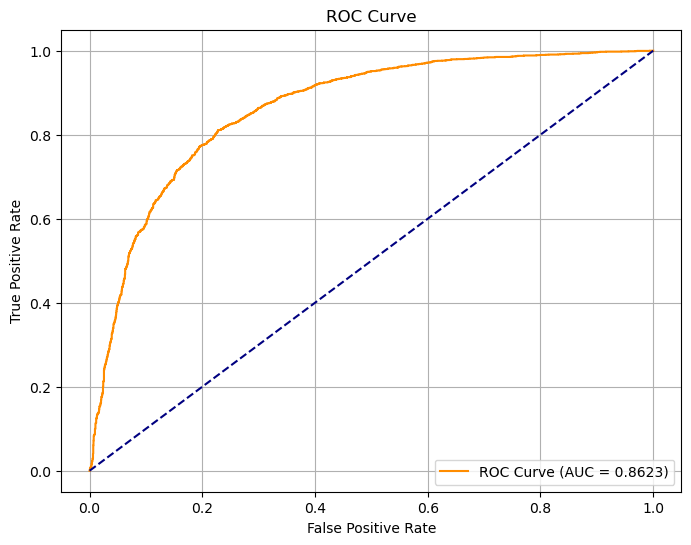

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Calculate probabilities, predictions, and true labels
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['text_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        useful = batch['useful'].to(device)
        labels = batch['labels'].to(device)

        # Get predictions and probabilities
        logits = model(input_ids=input_ids, attention_mask=attention_mask, useful_features=useful)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        # Collect results
        all_probs.extend(probs.cpu().numpy()[:, 1])  # Probabilities for positive class
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

import numpy as np
# Convert lists to numpy arrays for metric calculation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=0)
recall = recall_score(all_labels, all_preds, zero_division=0)
f1 = f1_score(all_labels, all_preds, zero_division=0)
roc_auc = roc_auc_score(all_labels, all_probs)

# Print metrics
print(f"Confusion Matrix:\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
